## classifisher
Here I try to classify images of fishes. I have a dataset, Fish_Dataset, with 9000 images of fishes. There are 9 different species, with 1000 images each.

This notebook follows my process, and is not intended to be a perfect solution. My plan was to investigate the data, get a MVP baseline model going and iterating. I didn't have time to iterate a lot or to do a thourough data investigation. I had to call it quits with an approach that I'm not quite happy with, but that's the reality of doing stuff I guess. Anyways, It was a fun project, and I learned a lot.

The notebook has three main parts:
1) data loading and analysis

2) training a MVP CNN from scratch

3) using transfer learning to build on a pre-trained model, MobileNetV2 (based on ImageNet)

In [1]:
# imports

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential


from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split


## Data loading and analysis

We start by looking at the dataset. An example image is shown below.
As we can see, all images are very similiar, especially with a similar background. This needs to be kept in mind, as this will probably impact generalization performance.

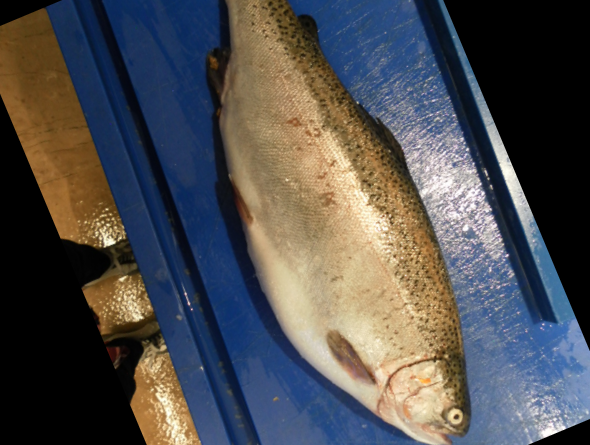

In [2]:
# example image
PIL.Image.open('Fish_Dataset/Forell/Forell/00001.png')

Here we load the data, using keras preprocessing. I use tensorflow datasets as a data pipeline. 

It's my first time using it, and I'm split in my impressions. It's a very fast and space efficient solution, but I had major problems with label indexing when trying to split data into a holdout set. At least I think that was the problem - I got amazing accuracy (too amazing I think) but when checking performance from predict with F1 I got almost exactly the expected value from random guessing. So I dropped the holdout testing, as I already spent many hours on debugging that and reatraining the models way too many times. So this is NOT a good, generalizable solution right now. 

In [66]:
# load data. Split 70-15-15 into train, validation, test
train_size = int(0.7*9000)
val_size = int(0.15*9000)
test_size = int(0.15*9000)

# I use quite small batch and image sizes to decrease computational and memory load, and to make 
# my computer not crash. Also 160x160 is compatible with MobileNetV2
batch_size = 16
img_height = 160 # actually 445
img_width = 160 # actually 540

full_ds = train_ds = keras.preprocessing.image_dataset_from_directory(
    'Fish_Dataset',
    shuffle = False,
    image_size = (img_height,img_width),
    batch_size=batch_size)

train_ds = keras.preprocessing.image_dataset_from_directory(
    'Fish_Dataset',
    validation_split=0.3,
    subset='training',
    seed = 1,
    image_size = (img_height,img_width),
    batch_size=batch_size)

val_ds = keras.preprocessing.image_dataset_from_directory(
    'Fish_Dataset',
    validation_split=0.3,
    subset='validation',
    seed = 1,
    image_size = (img_height,img_width),
    batch_size=batch_size)

# split into validation and testing - this made me waste 3 hours (I think). Made label indexing weird I think
# test_ds = val_ds.skip(test_size//batch_size)
# val_ds = val_ds.take(val_size//batch_size)

Found 9000 files belonging to 9 classes.
Found 9000 files belonging to 9 classes.
Using 6300 files for training.
Found 9000 files belonging to 9 classes.
Using 2700 files for validation.


In [37]:
# all class names / fish species

class_names = train_ds.class_names
print(class_names)

['Forell', 'Förgylld braxen', 'Havsaborre', 'Makrill', 'Randig multe', 'Räka', 'Röd braxen', 'Röd multe', 'Skarpsill']


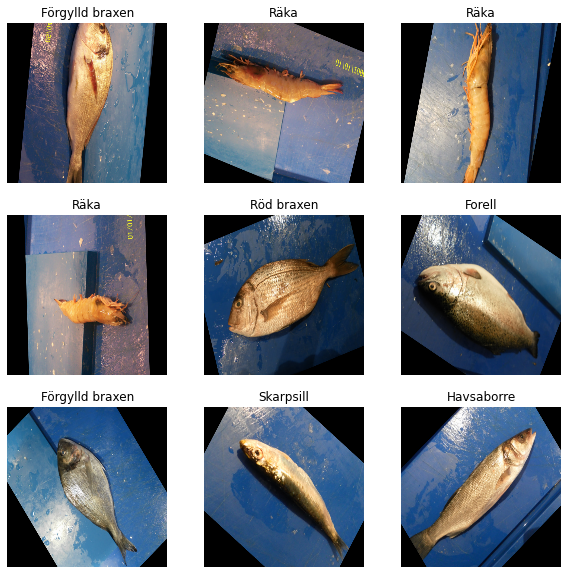

In [38]:
# here are the 9 first images in the training set. Here we see the similar backgrounds especially

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Here we have the first 9 images and their classes in the training dataset. We can see that the backgrounds are very homogenus for all pictures.

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


InvalidArgumentError: slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

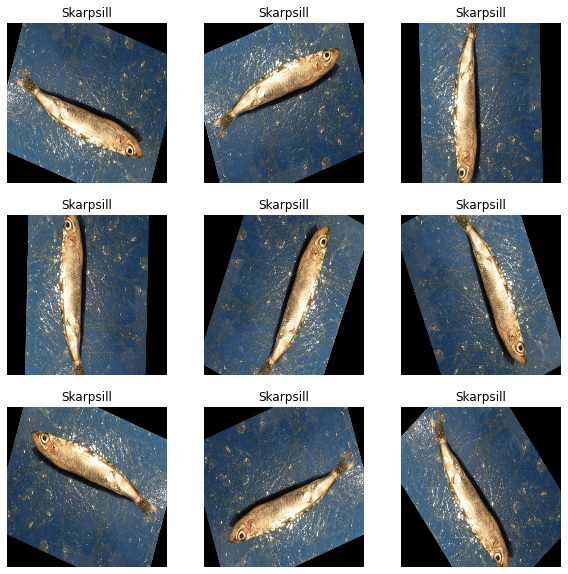

In [67]:
# more data analysis - here we can see that the data has been augmented by rotating images already
# I would estimate that there are about 10 augmentations per image - so the dataset is more like 100 images per species
# this makes this a very small dataset, with a high risk of overfitting

plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Here I have plotted 9 consequtive images from one of the classes, skarpsill. We can see that the data has been augmented by rotating images already. I would estimate that there are about 10 augmentations per image - so the dataset is more like 100 images per species. This makes this a very small dataset, with a high risk of overfitting

In [39]:
# cache and prefetch data for performance reasons. - performance improvement
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### MVP CNN-model

Here I create a straight forward CNN in keras.
First I add a data augmentation layer to improve generalization performance from this small dataset.
Then I have a straight forward network with 3 convolutional layers together with maxpooling, a quite large dense network and finally 9 outout nodes with a softmax activation function at the end. I also use dropout to improve robustness and generalization.

I train this for 10 epochs

In [12]:
# data augmentation - already rotated
# todo : look up more augs, reason for still rotating

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                input_shape=(img_height,
                                                            img_width,
                                                            3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

In [57]:
num_classes = 9

model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)       

In [58]:
epochs = 10
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
394/394 [==============================] - 190s 480ms/step - loss: 1.8022 - accuracy: 0.3114 - val_loss: 0.8914 - val_accuracy: 0.6648
Epoch 2/10
394/394 [==============================] - 178s 452ms/step - loss: 0.7826 - accuracy: 0.7133 - val_loss: 0.6073 - val_accuracy: 0.7841
Epoch 3/10
394/394 [==============================] - 178s 451ms/step - loss: 0.4884 - accuracy: 0.8243 - val_loss: 0.3111 - val_accuracy: 0.8870
Epoch 4/10
394/394 [==============================] - 191s 486ms/step - loss: 0.3751 - accuracy: 0.8656 - val_loss: 0.1378 - val_accuracy: 0.9478
Epoch 5/10
394/394 [==============================] - 175s 445ms/step - loss: 0.3076 - accuracy: 0.8886 - val_loss: 0.1762 - val_accuracy: 0.9363
Epoch 6/10
394/394 [==============================] - 174s 442ms/step - loss: 0.1979 - accuracy: 0.9296 - val_loss: 0.1818 - val_accuracy: 0.9367
Epoch 7/10
394/394 [==============================] - 170s 432ms/step - loss: 0.1600 - accuracy: 0.9461 - val_loss: 0.0671 -

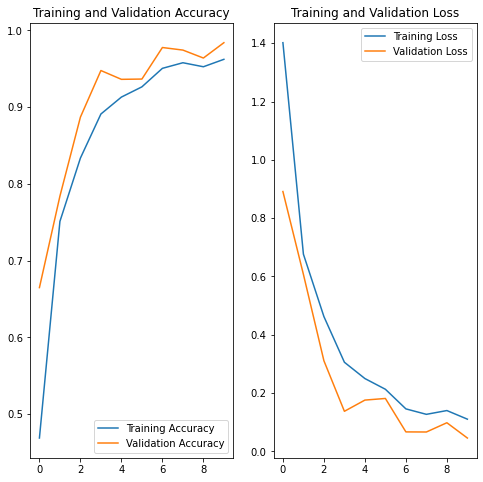

In [60]:
# visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Here we see the training performance. It looks amazing, too amazing I think. A 9 class classification problem should be harder to get 95% validation accuracy on. I think this performance is partly due to the similarity of all the images, and very small number of unique images.

Sidenote: the fact that the validation performance is better than the training performance is due to the fact that the data isn't augmented and dropout isn't used for the validation data.

In [12]:
# this is from when I used a holdout test dataset as well. As we can see, the accuracy was also amazing. 
# However, the confusion matrix and classification report was basically E[random guess]. 

model2.evaluate(test_ds)

85/85 [==============================] - 28s 200ms/step - loss: 0.0499 - accuracy: 0.9794


[0.049900807440280914, 0.9793510437011719]

Here I just validate that when I use the model to predict, nothing funky happens.
I want to (and used to) use a holdout set here, but as I've written way to many times now something strange made that not work at all. 

In [61]:
pred = model2.predict(val_ds)

In [62]:
pred_y = np.argmax(pred,axis=1)
y = np.concatenate([y for x,y in val_ds],axis=0)

In [63]:
confusion_matrix(y,pred_y)

array([[300,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 298,   6,   0,   0,   0,   2,   0,   0],
       [  1,   0, 296,   1,   0,   0,   2,   0,   5],
       [  0,   0,   0, 297,   0,   0,   0,   0,   0],
       [  0,   0,   3,   0, 278,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0, 290,   0,   0,   0],
       [  2,   3,   0,   1,   0,   0, 306,   0,   0],
       [  0,   0,   0,   0,  11,   3,   0, 306,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 286]], dtype=int64)

In [64]:
print(classification_report(y,pred_y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1       0.99      0.97      0.98       306
           2       0.97      0.97      0.97       305
           3       0.99      1.00      1.00       297
           4       0.96      0.98      0.97       284
           5       0.98      1.00      0.99       290
           6       0.99      0.98      0.98       312
           7       1.00      0.96      0.98       320
           8       0.98      1.00      0.99       286

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



Very good results. Too good I think, a f1-score of 98% on a 9-class classification problem seems way too good for such a simple model. I think the model is extremey overfit, since I have quite few images of each species and those images have already been augmented quite a bit.

I don't have time to test generalization performance now, but that would be the next step for sure.
First by finding a way to create a holdout test data subset from the images given (that doesn't make the label indexes mix and waste 3 hours of my life debugging).
And then by finding other images of these species that don't have a blue background and very clear images of the fishes.

### Transfer learning

Here I use transfer learning - i.e. I take an already trained network and adapt it to this task.
I do this by taking MobileNetV2 - a network based on ImageNet that is optimized for mobile phones. So great for my not so optimized laptop :)
I load MobileNet, but disregard the final layer as the second last is more generalizable. I make sure to freeze the network to keep it as is. I add some layers to preprocess the data to what MobileNet expects, to augment the inputs again. Then I add some layers at the very end of the network to output probabilities for our 9 fish species'.

Here I train ~11 k weights instead of ~ 3.3 M in the last network. Still takes the same amount of time per epoch for me though, so I think the I/O operations of the image data is the bottleneck on my setup.
That would also be a future area of improvement for this setup.

In [40]:
# use transfer learning. I use MobileNetV2, which is based on ImageNet

# preprocessing:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# import MobileNetV2, and freeze weights
IMG_SHAPE = (img_height,img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
________________

In [41]:
# feature extractor
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 5, 5, 1280)
(16, 1280)


In [42]:
# prediction layer
num_classes = 9

prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 9)


In [43]:
# data augmentation - already rotated
# todo : look up more augs, reason for still rotating

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal',
                                                input_shape=(img_height,
                                                            img_width,
                                                            3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

In [44]:
# build model

inputs = tf.keras.Input(shape=(img_height,img_width,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [45]:
# compile model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [31]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(val_ds)

84/84 [==============================] - 25s 273ms/step - loss: 2.8102 - accuracy: 0.0935


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.86
initial accuracy: 0.09


In [68]:
# train model
initial_epochs = 7 # in total 10 epochs here as well. I trained for 3 earlier to get some quicker iteration speed.

history = model.fit(train_ds,
                   epochs=initial_epochs,
                   validation_data = val_ds)

Epoch 1/7
394/394 [==============================] - 266s 672ms/step - loss: 0.3598 - accuracy: 0.9070 - val_loss: 0.3403 - val_accuracy: 0.8989
Epoch 2/7
394/394 [==============================] - 263s 664ms/step - loss: 0.2925 - accuracy: 0.9257 - val_loss: 0.2515 - val_accuracy: 0.9381
Epoch 3/7
394/394 [==============================] - 263s 666ms/step - loss: 0.2424 - accuracy: 0.9405 - val_loss: 0.2282 - val_accuracy: 0.9407
Epoch 4/7
394/394 [==============================] - 272s 689ms/step - loss: 0.2087 - accuracy: 0.9498 - val_loss: 0.1949 - val_accuracy: 0.9504
Epoch 5/7
394/394 [==============================] - 278s 705ms/step - loss: 0.1804 - accuracy: 0.9573 - val_loss: 0.1807 - val_accuracy: 0.9522
Epoch 6/7
394/394 [==============================] - 271s 686ms/step - loss: 0.1572 - accuracy: 0.9633 - val_loss: 0.1701 - val_accuracy: 0.9530
Epoch 7/7
394/394 [==============================] - 268s 678ms/step - loss: 0.1483 - accuracy: 0.9632 - val_loss: 0.1650 - val_ac

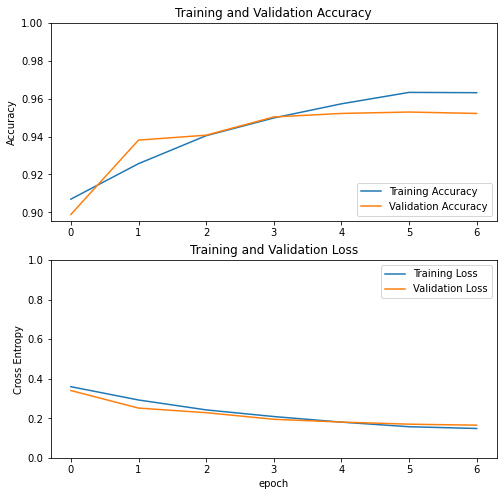

In [69]:
# visualize learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Doesn't show first three epochs, as I trained a quick first iteration to check it out quickly.

In [70]:
pred = model.predict(val_ds)

In [31]:
# same as for earlier model. Used holdout before - really good accuracy but awful predictions.
model.evaluate(test_ds)

85/85 [==============================] - 43s 380ms/step - loss: 0.4026 - accuracy: 0.8776


[0.4025898575782776, 0.8775811195373535]

In [71]:
pred_y = np.argmax(pred,axis=1)
y = np.concatenate([y for x,y in val_ds],axis=0)

#### Here we have the same issue that I've been wrestling with most of the day.
It worked after 3 epochs but not after 7 more. Super weird. I thought it had something to do with a dataset split I made earlier, but apparently not.

I give up at this point, this is how i'll have to leave it I guess.

In [72]:
confusion_matrix(pred_y,y)

array([[27, 28, 21, 30, 27, 26, 35, 29, 30],
       [23, 38, 39, 25, 35, 35, 37, 32, 25],
       [39, 44, 44, 32, 43, 41, 55, 40, 46],
       [46, 35, 20, 33, 27, 34, 27, 40, 36],
       [26, 26, 37, 34, 30, 27, 27, 34, 32],
       [31, 33, 42, 33, 30, 31, 29, 30, 28],
       [33, 33, 37, 43, 41, 36, 43, 41, 28],
       [46, 45, 31, 29, 23, 35, 27, 48, 33],
       [29, 24, 34, 38, 28, 25, 32, 26, 28]], dtype=int64)

In [73]:
print(classification_report(y,pred_y,target_names=class_names))

                 precision    recall  f1-score   support

         Forell       0.11      0.09      0.10       300
Förgylld braxen       0.13      0.12      0.13       306
     Havsaborre       0.11      0.14      0.13       305
        Makrill       0.11      0.11      0.11       297
   Randig multe       0.11      0.11      0.11       284
           Räka       0.11      0.11      0.11       290
     Röd braxen       0.13      0.14      0.13       312
      Röd multe       0.15      0.15      0.15       320
      Skarpsill       0.11      0.10      0.10       286

       accuracy                           0.12      2700
      macro avg       0.12      0.12      0.12      2700
   weighted avg       0.12      0.12      0.12      2700



### Finishing thoughts
I will end it here as it is getting very late. I have learned a lot from this project. I had a clear plan from the begining to first analyze the data, then get a MVP-model going and then to iterate. 
I did manage that, but I didn't have time to iterate a lot. And I got stuck in some time-sinks that I didn't expect at all going in.

I had one big pivot: first I used just numpy arrays for all data and labels. But that made the data wrangling more complex that the model training for me, so I threw that first iteration away. I used tf datasets as data structures after that. That led to other challenges. I spent most of my time confused as for why I got great accuracy results but awful predictions. I didn't solve it conclusively, but I think it had something to do with using keras preprocesssing and then just using dataset.take() and dataset.skip() to split validation and testing data.

I got way better results than I think is reasonable. The next step for me would be to investigate generalization performance. First by some sort of holdout, and then by finding completely different pictures, preferably without a blue background. And maybe try some cross validation and/or bagging. Also try to augment the images in other ways, as they were already rotated. 

And also to find the reason for why predict doesn't work most of the time! I thought I had it fixed, but just when I ran a few more training epochs as the last thing I'd do before going to bed, it stopped working again.